In [1]:
from astropy.table import Table, vstack, unique, SortedArray
import glob
import numpy
import time
from datetime import date, timedelta, datetime
import psycopg2
import sqlite3
import pandas as pd
from functools import reduce
from desispec.io import read_spectra, write_spectra
from desispec.spectra import Spectra

import matplotlib.pyplot as plt
import os
from desiutil.log import get_logger, DEBUG

In [2]:
# arguments:
#  yyyymmdd of the night of interest
# outputs:
#  tile_petal: subsets of tile/petals whose RA/DEC targets are not contained in other tile/petals from that night
#  group_tid: the set of targetid's associated with each RA/DEC
#  group_tp:  the set of tile/petals associated with each RA/DEC

def getMatchedTileid(yyyymmdd):
    
    # read in and store in one place all the fibermap information in the spectra files
    dats=[]
    for filename in glob.glob(f"/global/project/projectdirs/desi/spectro/redux/daily/tiles/cumulative/*/{yyyymmdd}/spectra-*.fits"):
        t = Table.read(filename, format='fits',hdu=1, memmap=True) \
            [['TARGETID','TARGET_RA','TARGET_DEC','TILEID','OBJTYPE','PETAL_LOC','FIBERSTATUS','NIGHT']]
        
        """
        For David include only things that have at least one _TARGET non-zero or null
        """
        t=t[numpy.logical_and(t['OBJTYPE']=='TGT', t['FIBERSTATUS']==0)]
        dats.append(t)
    dats=vstack(dats, join_type='inner',metadata_conflicts='silent')

    # group all the observations by TARGET_RA and TARGET_DEC
    # note that this is more reliable than grouping by TARGETID as TARGETID is NOT a unique identifier of RA and DEC
    dats_group = dats.group_by(['TARGET_RA','TARGET_DEC'])
    
    # for each group make a list of all targetid's with that ra/dec
    group_tid=[]
    group_night=[]
    # for each group make a tuple containing all tileid/petal combinations that have that ra/dec
    group_tp=[]    
    for g in dats_group.groups:
        group_tid.append(numpy.unique(g['TARGETID'].data))
        group_night.append(numpy.unique(g['NIGHT'].data))
#     for g in dats_group.groups:
        gu = unique(g,keys=['TILEID'])
        dum=[]
        for a,b in zip(gu['TILEID'],gu['PETAL_LOC']):
            dum.append((a,b))
        group_tp.append(tuple(dum))

    # compress things down to the unique tile/petal combinations
    ans = list(set(group_tp))
    
    # union sets that have intersecting tile/petal combinations
    for i in range(len(ans)-1,0,-1):
        for j in range(i-1,-1,-1):
            if len(set(ans[i]) & set(ans[j])) !=0:
                ans[j]=ans[i]+ans[j]
                del ans[i]
                break

    # unique of each set
    for i in range(len(ans)):
        ans[i]=list(set(ans[i]))
        
    tile_petal=ans
        
    # for each set the TARGET_RA TARGET_DEC associated
        
    return(tile_petal, group_tid, group_tp, group_night)

In [3]:
yyyymmdd=20210606
tile_petal,group_tid,group_tp, group_night =getMatchedTileid(yyyymmdd)

In [5]:
date = yyyymmdd
# tile_petal contain subsets of tile/petals whose RA/DEC targets are not contained in other tile/petals from that night
for tps in tile_petal:
    # cache spectra to minimize IO
    spectra_list=dict()
    target_list=[]
    for tp in tps:
        filename =  f"/global/project/projectdirs/desi/spectro/redux/daily/tiles/cumulative/{tp[0]}/{yyyymmdd}/spectra-{tp[1]}-{tp[0]}-thru{yyyymmdd}.fits"
        spectra_list[(tp[0],tp[1])]=read_spectra(filename)
    
    # loop over all unique RA/DEC pairs from that night
    for tid, tp, night in zip(group_tid,group_tp,group_night):
        # if this RA/DEC is not in thie tile_petal combination than skip
        if tp[0] not in tps:
            continue
        # Eliminate those with no reference night here
        # Proceed with a subtraction for this object
        
        # The coadds of the new and reference are constructed from all spectra with all targetid's in tid and all
        # tile/petal combinations in tp, which are cached above
        print(tid, tp)
        newSpectra=[]
        refSpectra=[]
        
        for tile,plate in tp:
            spec = spectra_list[(tile,plate)]
            newSpectra.append(spec.select(nights=date, targets = tid))
            
            """
            There is a variable night that has all the nights associated with this RA/DEC
            derive the ref_night from that
            """
            
            refSpectra.append(spec.select(nights=ref_night, targets = tid))
            
        
        newflux, newivar, newmask = coadd(newSpectra)
        refflux, refivar, refmask = coadd(refSpectra)
       
        difflux, difivar, difmask = dict.fromkeys(["b", "r", "z"]), dict.fromkeys(["b", "r", "z"]), dict.fromkeys(["b", "r", "z"])
        
        difflux = {key: newflux[key] - refflux.get(key, 0)
                       for key in newflux.keys()}
        difivar = {key: newivar[key] - refivar.get(key, 0)
                       for key in newivar.keys()}
        difmask = {key: numpy.logical_and(newmask[key], refmask.get(key, 0))
                       for key in test_dict2.keys()}
        """
        assignment to a differenced Spectra object 
        """
        
                
        
        

INFO:spectra.py:253:read_spectra: iotime 1.005 sec to read spectra-6-1239-thru20210606.fits at 2021-08-21T16:50:56.874811
[39628512646138870] ((1239, 6),)


TypeError: argument of type 'type' is not iterable

In [ ]:
def coadd(newSpectra):
    sflux, ssumivar, sivar, smask = dict(), dict(), dict(), dict()
        
    first = True
    for s in newSpectra: # why/how would there be multiple spectra in s? 
        if first: 
            for b in s.bands:
                sflux[b]=s.flux[b]*s.ivar[b]
                ssumivar[b]=s.ivar[b]
                sivar[b] = 1/s.ivar[b]
                smask[b]=s.mask[b]
            first=False
        else:
            for b in s.bands:
                sflux[b] += s.flux[b]*s.ivar[b]
                ssumivar[b] += s.ivar[b]
                sivar[b] += 1/s.ivar[b]
                smask[b] = numpy.logical_and(smask[b],s.mask[b])
    for b in s.bands:
        sflux[b] = sflux[b]/ssumivar[b] 
        sivar[b] = 1/sivar[b] 
    
    return(sflux, sivar, smask)


In [33]:
print(spec.mask)

{'b': array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [512, 512, 512, ..., 512, 512, 512],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint32), 'r': array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [512, 512, 512, ..., 512, 512, 512],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint32), 'z': array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [512, 512, 512, ..., 512, 512, 512],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint32)}


In [13]:
print(tid, tp)
newSpectra=[]
refSpectra=[]

unique_night = numpy.unique(night)

date = numpy.array(yyyymmdd)
idx = numpy.in1d(unique_night, date)
ref_night = unique_night[~idx]

for tile,plate in tp:
    spec = spectra_list[(tile,plate)]
    newSpectra.append(spec.select(nights=date, targets = tid))

    """
    There is a variable night that has all the nights associated with this RA/DEC
    derive the ref_night from that
    """

    refSpectra.append(spec.select(nights=ref_night, targets = tid))


[39628512646138870] ((1239, 6),)


RuntimeError: no valid nights were selected!

In [12]:
night_arr = getUnprocessedDates()
print(night_arr)

len(night_arr): 20
--- get unprocessed dates took:  9.327675104141235 seconds ---
[20210606 20210607 20210614 20210615 20210616 20210617 20210618 20210619
 20210620 20210621 20210626 20210627 20210628 20210629 20210704 20210705
 20210706 20210707 20210708 20210709]


In [4]:

# read in and store in one place all the fibermap information in the spectra files
yyyymmdd = 20210606
dats=[]
for filename in glob.glob(f"/global/project/projectdirs/desi/spectro/redux/daily/tiles/cumulative/*/{yyyymmdd}/spectra-*.fits"):
    t = Table.read(filename, format='fits',hdu=1, memmap=True)[['TARGETID','TARGET_RA','TARGET_DEC','TILEID','OBJTYPE','PETAL_LOC', 'NIGHT']]
    t=t[t['OBJTYPE']=='TGT']
    dats.append(t)
dats=vstack(dats, join_type='inner',metadata_conflicts='silent')
# group all the observations by TARGET_RA and TARGET_DEC
# note that this is more reliable than grouping by TARGETID as TARGETID is NOT a unique identifier of RA and DEC
dats_group = dats.group_by(['TARGET_RA','TARGET_DEC'])

# for each group make a tuple containing all tileid/petal combinations that have that ra/dec
tile_petal=[]
# for each group, determine the unique nights that occur
night=[]
for g in dats_group.groups:

    gu = unique(g, keys=['TILEID'])

    dum=[]
    for a,b,c in zip(gu['TILEID'],gu['PETAL_LOC'],gu['TARGETID']):
        dum.append((a,b,c))
    tile_petal.append(tuple(dum))


    du = unique(g, keys=['NIGHT'])

    for d in zip(du['NIGHT']):
        night.append((d))


# compress things down to the unique tile/petal combinations
tile_petal = list(set(tile_petal))
# union sets that have intersecting tile/petal combinations
for i in range(len(tile_petal)-1,0,-1):
    for j in range(i-1,-1,-1):
        if len(set(tile_petal[i]) & set(tile_petal[j])) !=0:
            tile_petal[j]=tile_petal[i]+tile_petal[j]
            del tile_petal[i]
            break
# unique of each set
for i in range(len(tile_petal)):
    tile_petal[i]=list(set(tile_petal[i]))


unique_night = numpy.unique(night)

for i in tile_petal:
    spectra = Spectra()
    dif_spectra = Spectra()
    ref_spectra = Spectra() ###or else NameError at 'if ref_spectra.num_spectra'... in the case of no reference nights
    for j in i:
        filename =  f"/global/project/projectdirs/desi/spectro/redux/daily/tiles/cumulative/{j[0]}/{yyyymmdd}/spectra-{j[1]}-{j[0]}-thru{yyyymmdd}.fits"
        spectra = read_spectra(filename)
        date = numpy.array(yyyymmdd)
        idx = numpy.in1d(unique_night, date)
        ref_night = unique_night[~idx]

        try:
            cur_spectra = (spectra.select(nights=date, targets = [j[2]]))
            ref_spectra = (spectra.select(nights=ref_night, targets = [j[2]]))
        except:
            pass ###this is the mechanism for eliminating targets that have no reference nights. 
        print('ref spectra num :')
        print(ref_spectra.num_spectra())
        print('cur spectra num :')
        print(cur_spectra.num_spectra())
        
        if ref_spectra.num_spectra() != 0:
        ###in the case of no ref nights, as 'pass' has allowed a reference spectra to be created despite a RuntimeError, this is the check that there is something to difference
            first = True
            for s in cur_spectra: ### is newSpectra meant to be a Spectra object or a list of Spectra objects?
                for b in s.bands:
                    if s==cur_spectra[0]:
                        newflux[b]=s.flux[b]*s.ivar[b]
                        sumivar[b]=s.ivar[b]
                        newivar[b] = 1/s.ivar[b]
                        newmask[b]=s.mask[b]
                        first=False
                    else:
                        newflux[b] += s.flux[b]*s.ivar[b]
                        sumivar[b] += s.ivar[b]
                        newivar[b] += 1/s.ivar[b]
                        newmask[b] = numpy.logical_and(newmask[b],s.mask[b])
                    cur_spectra.flux[b] = newflux[b]/sumivar[b] ### assumption here that newSpectra is a Spectra object
                    cur_spectra.ivar[b] = 1/newivar[b] ### ditto

            """
            Something similar for reference

            Then difference
            """
            first = True
            for s in ref_spectra: ### is newSpectra meant to be a Spectra object or a list of Spectra objects?
                for b in s.bands:
                    if s==ref_spectra[0]: ### if refSpectra is
                        newflux[b]=s.flux[b]*s.ivar[b]
                        sumivar[b]=s.ivar[b]
                        newivar[b] = 1/s.ivar[b]
                        newmask[b]=s.mask[b]
                        first=False
                    else:
                        newflux[b] += s.flux[b]*s.ivar[b]
                        sumivar[b] += s.ivar[b]
                        newivar[b] += 1/s.ivar[b]
                        newmask[b] = numpy.logical_and(newmask[b],s.mask[b])
                    refSpectra.flux[b] = newflux[b]/sumivar[b]
                    refSpectra.ivar[b] = 1/newivar[b]

            difSpectra.update(newSpectra)
            for b in difSpectra.bands:
                difSpectra.flux[b] -= ref_spectra.flux[b]




INFO:spectra.py:253:read_spectra: iotime 0.958 sec to read spectra-5-1222-thru20210606.fits at 2021-08-25T19:55:11.928597
ref spectra num :
0
cur spectra num :
1
INFO:spectra.py:253:read_spectra: iotime 0.891 sec to read spectra-0-2203-thru20210606.fits at 2021-08-25T19:55:13.218953
ref spectra num :
0
cur spectra num :
1
INFO:spectra.py:253:read_spectra: iotime 0.785 sec to read spectra-0-1222-thru20210606.fits at 2021-08-25T19:55:14.381313
ref spectra num :
0
cur spectra num :
1
INFO:spectra.py:253:read_spectra: iotime 0.957 sec to read spectra-4-2197-thru20210606.fits at 2021-08-25T19:55:15.725664
ref spectra num :
0
cur spectra num :
1
INFO:spectra.py:253:read_spectra: iotime 0.863 sec to read spectra-8-2163-thru20210606.fits at 2021-08-25T19:55:16.973789
ref spectra num :
0
cur spectra num :
1
INFO:spectra.py:253:read_spectra: iotime 0.894 sec to read spectra-5-1239-thru20210606.fits at 2021-08-25T19:55:18.231741
ref spectra num :
0
cur spectra num :
1
INFO:spectra.py:253:read_spe

NameError: name 'newflux' is not defined

# for each group make a tuple containing all tileid/petal combinations that have that ra/dec
# compress things down to the unique tile/petal combinations
# union sets that have intersecting tile/petal combinations
#  compress night into only one instance of each
[20210602 20210606]
--- 5604.607462882996 seconds ---
INFO:spectra.py:253:read_spectra: iotime 2.161 sec to read spectra-5-1222-thru20210606.fits at 2021-08-05T17:24:44.988599
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.009 sec to read spectra-0-2203-thru20210606.fits at 2021-08-05T17:24:48.350448
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.135 sec to read spectra-0-1222-thru20210606.fits at 2021-08-05T17:24:49.917786
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.031 sec to read spectra-4-2197-thru20210606.fits at 2021-08-05T17:24:52.282724
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.216 sec to read spectra-8-2163-thru20210606.fits at 2021-08-05T17:24:53.939580
[20210602]
INFO:spectra.py:25

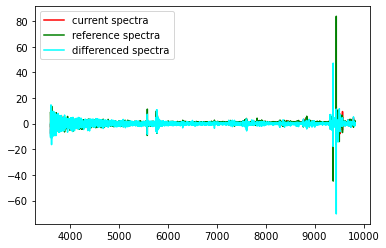

INFO:spectra.py:253:read_spectra: iotime 1.033 sec to read spectra-1-21195-thru20210606.fits at 2021-08-05T17:25:19.280056
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.957 sec to read spectra-5-1222-thru20210606.fits at 2021-08-05T17:25:20.681458
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.025 sec to read spectra-4-1219-thru20210606.fits at 2021-08-05T17:25:22.160049
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.083 sec to read spectra-5-20111-thru20210606.fits at 2021-08-05T17:25:23.723773
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.133 sec to read spectra-1-1222-thru20210606.fits at 2021-08-05T17:25:25.299540
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.989 sec to read spectra-2-1394-thru20210606.fits at 2021-08-05T17:25:26.731316
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.975 sec to read spectra-2-1222-thru20210606.fits at 2021-08-05T17:25:28.148062
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.989 sec to read spectra-

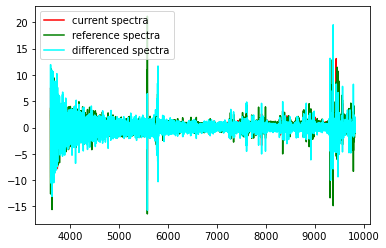

INFO:spectra.py:253:read_spectra: iotime 1.459 sec to read spectra-6-1117-thru20210606.fits at 2021-08-05T17:27:20.287136
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.199 sec to read spectra-2-1219-thru20210606.fits at 2021-08-05T17:27:22.340074
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.957 sec to read spectra-7-1423-thru20210606.fits at 2021-08-05T17:27:23.737211
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.419 sec to read spectra-0-1117-thru20210606.fits at 2021-08-05T17:27:25.585630
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.433 sec to read spectra-4-1117-thru20210606.fits at 2021-08-05T17:27:28.463284
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.916 sec to read spectra-7-21089-thru20210606.fits at 2021-08-05T17:27:30.239387
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.130 sec to read spectra-8-1219-thru20210606.fits at 2021-08-05T17:27:31.870248
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.422 sec to read spectra-5

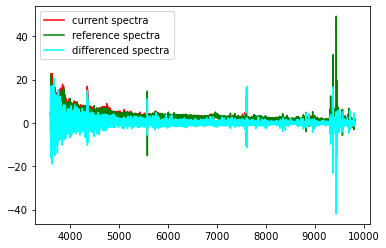

INFO:spectra.py:253:read_spectra: iotime 1.493 sec to read spectra-3-1117-thru20210606.fits at 2021-08-05T17:28:02.034772
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.424 sec to read spectra-2-1117-thru20210606.fits at 2021-08-05T17:28:04.490128
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.878 sec to read spectra-1-21195-thru20210606.fits at 2021-08-05T17:28:06.189542
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.992 sec to read spectra-8-1222-thru20210606.fits at 2021-08-05T17:28:07.613244
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.991 sec to read spectra-5-21089-thru20210606.fits at 2021-08-05T17:28:09.053870
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.978 sec to read spectra-5-20112-thru20210606.fits at 2021-08-05T17:28:10.465604
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.989 sec to read spectra-6-20111-thru20210606.fits at 2021-08-05T17:28:11.886071
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.168 sec to read spectr

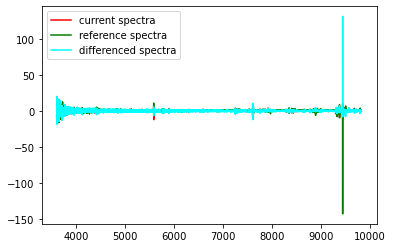

INFO:spectra.py:253:read_spectra: iotime 0.969 sec to read spectra-9-2163-thru20210606.fits at 2021-08-05T17:28:22.584446
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.116 sec to read spectra-2-2197-thru20210606.fits at 2021-08-05T17:28:24.136438
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.124 sec to read spectra-3-1407-thru20210606.fits at 2021-08-05T17:28:25.703984
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.184 sec to read spectra-0-1423-thru20210606.fits at 2021-08-05T17:28:27.320451
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.964 sec to read spectra-7-1230-thru20210606.fits at 2021-08-05T17:28:28.716183
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.141 sec to read spectra-0-1910-thru20210606.fits at 2021-08-05T17:28:30.309259
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.471 sec to read spectra-4-1882-thru20210606.fits at 2021-08-05T17:28:32.218819
[20210602]


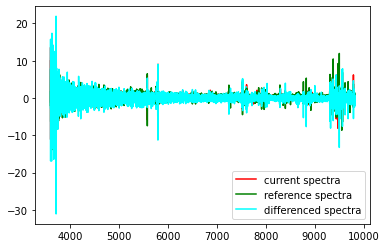

INFO:spectra.py:253:read_spectra: iotime 1.032 sec to read spectra-6-2203-thru20210606.fits at 2021-08-05T17:28:36.637068
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.344 sec to read spectra-5-1200-thru20210606.fits at 2021-08-05T17:28:38.438519
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.960 sec to read spectra-9-1200-thru20210606.fits at 2021-08-05T17:28:39.853072
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.999 sec to read spectra-2-21195-thru20210606.fits at 2021-08-05T17:28:41.290663
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.917 sec to read spectra-0-1239-thru20210606.fits at 2021-08-05T17:28:42.666721
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.012 sec to read spectra-8-20112-thru20210606.fits at 2021-08-05T17:28:44.105904
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.979 sec to read spectra-9-1246-thru20210606.fits at 2021-08-05T17:28:45.581786
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.957 sec to read spectra-

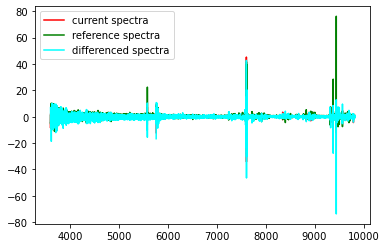

INFO:spectra.py:253:read_spectra: iotime 0.985 sec to read spectra-5-2203-thru20210606.fits at 2021-08-05T17:29:14.036284
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.947 sec to read spectra-1-2203-thru20210606.fits at 2021-08-05T17:29:15.415731
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.184 sec to read spectra-7-1246-thru20210606.fits at 2021-08-05T17:29:17.042569
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.895 sec to read spectra-8-1882-thru20210606.fits at 2021-08-05T17:29:19.419777
[20210602]


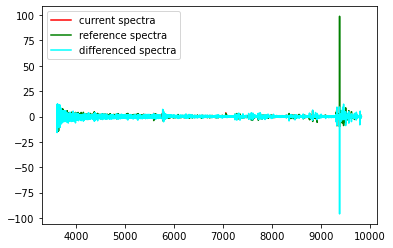

INFO:spectra.py:253:read_spectra: iotime 1.016 sec to read spectra-7-20079-thru20210606.fits at 2021-08-05T17:29:22.556562
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.989 sec to read spectra-0-1394-thru20210606.fits at 2021-08-05T17:29:24.046593
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.375 sec to read spectra-3-1117-thru20210606.fits at 2021-08-05T17:29:25.856178
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.943 sec to read spectra-7-1407-thru20210606.fits at 2021-08-05T17:29:27.629237
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.978 sec to read spectra-2-1423-thru20210606.fits at 2021-08-05T17:29:29.038929
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.986 sec to read spectra-2-1246-thru20210606.fits at 2021-08-05T17:29:30.456311
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.035 sec to read spectra-8-2203-thru20210606.fits at 2021-08-05T17:29:31.935093
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.163 sec to read spectra-4

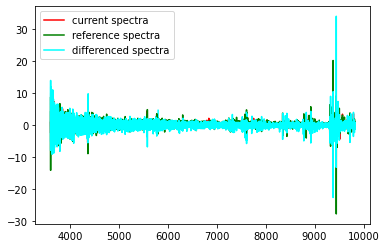

INFO:spectra.py:253:read_spectra: iotime 0.970 sec to read spectra-7-1394-thru20210606.fits at 2021-08-05T17:29:42.477302
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.986 sec to read spectra-3-20079-thru20210606.fits at 2021-08-05T17:29:43.927354
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.967 sec to read spectra-4-1200-thru20210606.fits at 2021-08-05T17:29:45.327583
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.019 sec to read spectra-9-2197-thru20210606.fits at 2021-08-05T17:29:46.794711
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.980 sec to read spectra-4-1407-thru20210606.fits at 2021-08-05T17:29:48.220224
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.009 sec to read spectra-8-21195-thru20210606.fits at 2021-08-05T17:29:49.696567
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.079 sec to read spectra-5-1910-thru20210606.fits at 2021-08-05T17:29:51.206732
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.989 sec to read spectra-

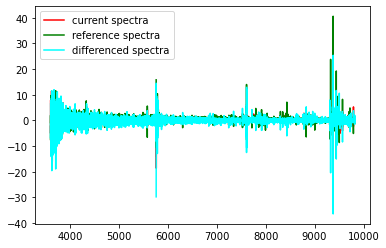

INFO:spectra.py:253:read_spectra: iotime 1.083 sec to read spectra-5-2163-thru20210606.fits at 2021-08-05T17:30:14.768026
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.943 sec to read spectra-6-1423-thru20210606.fits at 2021-08-05T17:30:16.146786
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.996 sec to read spectra-0-1219-thru20210606.fits at 2021-08-05T17:30:17.579425
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.205 sec to read spectra-3-1394-thru20210606.fits at 2021-08-05T17:30:19.221812
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.074 sec to read spectra-5-2197-thru20210606.fits at 2021-08-05T17:30:20.754876
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.383 sec to read spectra-1-1882-thru20210606.fits at 2021-08-05T17:30:22.632806
[20210602]


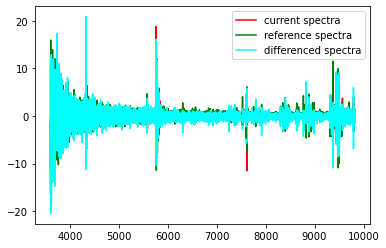

INFO:spectra.py:253:read_spectra: iotime 1.136 sec to read spectra-9-1239-thru20210606.fits at 2021-08-05T17:30:25.744058
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.975 sec to read spectra-8-1222-thru20210606.fits at 2021-08-05T17:30:27.141635
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.154 sec to read spectra-3-1423-thru20210606.fits at 2021-08-05T17:30:28.725552
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.970 sec to read spectra-8-1387-thru20210606.fits at 2021-08-05T17:30:30.131220
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.021 sec to read spectra-9-20112-thru20210606.fits at 2021-08-05T17:30:31.629517
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.175 sec to read spectra-2-1910-thru20210606.fits at 2021-08-05T17:30:33.234136
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.900 sec to read spectra-2-1910-thru20210606.fits at 2021-08-05T17:30:34.571050
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.950 sec to read spectra-1

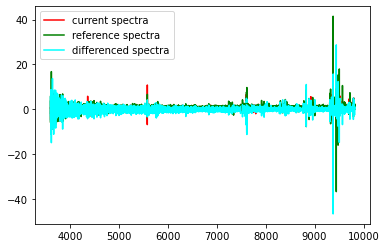

INFO:spectra.py:253:read_spectra: iotime 1.024 sec to read spectra-4-21195-thru20210606.fits at 2021-08-05T17:30:44.564167
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.174 sec to read spectra-0-1387-thru20210606.fits at 2021-08-05T17:30:46.186824
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.100 sec to read spectra-7-20112-thru20210606.fits at 2021-08-05T17:30:47.768878
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.978 sec to read spectra-1-1230-thru20210606.fits at 2021-08-05T17:30:49.184597
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.999 sec to read spectra-2-2163-thru20210606.fits at 2021-08-05T17:30:50.649312
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.994 sec to read spectra-9-1407-thru20210606.fits at 2021-08-05T17:30:52.077047
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.056 sec to read spectra-3-1246-thru20210606.fits at 2021-08-05T17:30:53.567541
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.947 sec to read spectra-

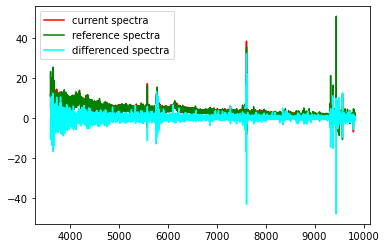

INFO:spectra.py:253:read_spectra: iotime 1.007 sec to read spectra-8-1395-thru20210606.fits at 2021-08-05T17:32:02.161801
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.185 sec to read spectra-6-20079-thru20210606.fits at 2021-08-05T17:32:03.854856
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.356 sec to read spectra-2-1882-thru20210606.fits at 2021-08-05T17:32:05.634531
[20210602]


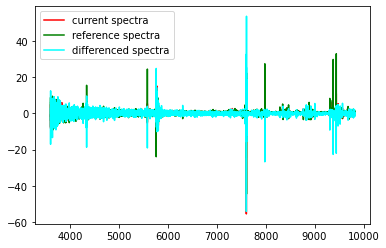

INFO:spectra.py:253:read_spectra: iotime 0.944 sec to read spectra-0-20079-thru20210606.fits at 2021-08-05T17:32:08.305828
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.970 sec to read spectra-2-1387-thru20210606.fits at 2021-08-05T17:32:09.717596
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.161 sec to read spectra-2-20112-thru20210606.fits at 2021-08-05T17:32:11.312380
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.025 sec to read spectra-9-2203-thru20210606.fits at 2021-08-05T17:32:12.772666
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.995 sec to read spectra-1-1222-thru20210606.fits at 2021-08-05T17:32:14.222640
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.973 sec to read spectra-0-1239-thru20210606.fits at 2021-08-05T17:32:15.632592
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.002 sec to read spectra-9-20079-thru20210606.fits at 2021-08-05T17:32:17.071445
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.966 sec to read spectra

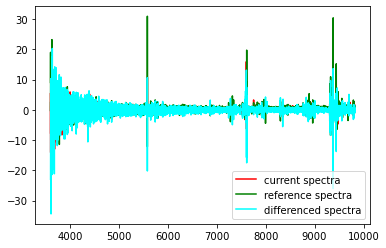

INFO:spectra.py:253:read_spectra: iotime 1.173 sec to read spectra-0-1395-thru20210606.fits at 2021-08-05T17:32:24.975482
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.027 sec to read spectra-6-1219-thru20210606.fits at 2021-08-05T17:32:26.445642
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.021 sec to read spectra-9-1242-thru20210606.fits at 2021-08-05T17:32:27.950911
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.181 sec to read spectra-3-1222-thru20210606.fits at 2021-08-05T17:32:29.621090
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.028 sec to read spectra-1-21089-thru20210606.fits at 2021-08-05T17:32:31.092675
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.010 sec to read spectra-9-1407-thru20210606.fits at 2021-08-05T17:32:32.546659
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.090 sec to read spectra-2-2197-thru20210606.fits at 2021-08-05T17:32:34.084349
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.016 sec to read spectra-6

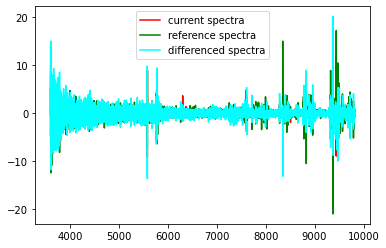

INFO:spectra.py:253:read_spectra: iotime 0.952 sec to read spectra-8-1418-thru20210606.fits at 2021-08-05T17:33:41.363014
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.094 sec to read spectra-4-1239-thru20210606.fits at 2021-08-05T17:33:42.896362
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.378 sec to read spectra-3-1882-thru20210606.fits at 2021-08-05T17:33:44.692334
[20210602]


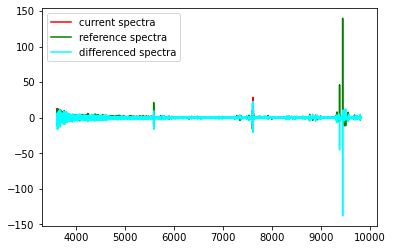

INFO:spectra.py:253:read_spectra: iotime 0.959 sec to read spectra-0-1239-thru20210606.fits at 2021-08-05T17:33:47.236330
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.976 sec to read spectra-5-2203-thru20210606.fits at 2021-08-05T17:33:48.717444
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.938 sec to read spectra-1-20112-thru20210606.fits at 2021-08-05T17:33:50.095912
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.942 sec to read spectra-2-1418-thru20210606.fits at 2021-08-05T17:33:51.458895
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.000 sec to read spectra-2-1407-thru20210606.fits at 2021-08-05T17:33:52.895638
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.976 sec to read spectra-2-1242-thru20210606.fits at 2021-08-05T17:33:54.322603
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.941 sec to read spectra-8-1239-thru20210606.fits at 2021-08-05T17:33:55.691569
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.914 sec to read spectra-3

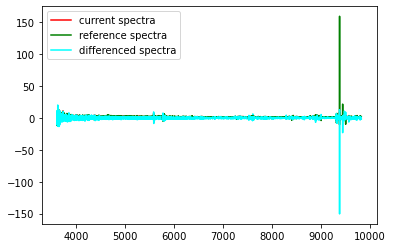

INFO:spectra.py:253:read_spectra: iotime 0.996 sec to read spectra-7-1407-thru20210606.fits at 2021-08-05T17:34:43.749197
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.214 sec to read spectra-4-20112-thru20210606.fits at 2021-08-05T17:34:45.414258
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.139 sec to read spectra-6-1242-thru20210606.fits at 2021-08-05T17:34:47.024122
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.020 sec to read spectra-0-1395-thru20210606.fits at 2021-08-05T17:34:48.467914
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.970 sec to read spectra-0-1418-thru20210606.fits at 2021-08-05T17:34:49.866869
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.934 sec to read spectra-6-1394-thru20210606.fits at 2021-08-05T17:34:51.242641
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.111 sec to read spectra-7-2203-thru20210606.fits at 2021-08-05T17:34:52.783477
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.183 sec to read spectra-5

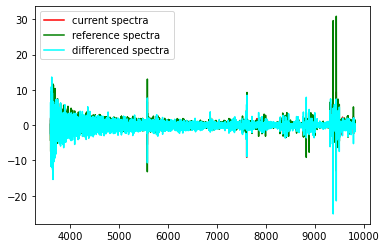

INFO:spectra.py:253:read_spectra: iotime 1.048 sec to read spectra-0-20079-thru20210606.fits at 2021-08-05T17:35:06.171597
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.002 sec to read spectra-4-1239-thru20210606.fits at 2021-08-05T17:35:07.625920
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.182 sec to read spectra-9-21089-thru20210606.fits at 2021-08-05T17:35:09.234353
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.976 sec to read spectra-1-1242-thru20210606.fits at 2021-08-05T17:35:10.643856
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.050 sec to read spectra-6-1230-thru20210606.fits at 2021-08-05T17:35:12.158762
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.023 sec to read spectra-1-2203-thru20210606.fits at 2021-08-05T17:35:13.618057
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.952 sec to read spectra-4-1239-thru20210606.fits at 2021-08-05T17:35:14.995503
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.932 sec to read spectra-

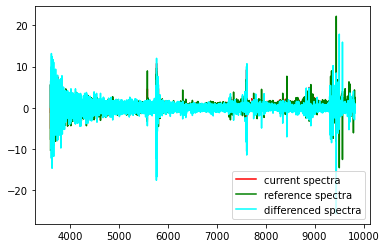

INFO:spectra.py:253:read_spectra: iotime 1.613 sec to read spectra-3-1882-thru20210606.fits at 2021-08-05T17:35:42.817260
[20210602]


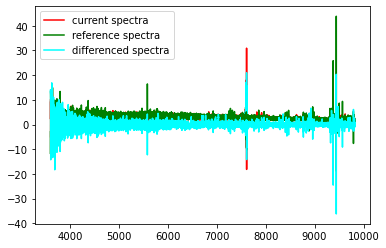

INFO:spectra.py:253:read_spectra: iotime 0.993 sec to read spectra-3-2163-thru20210606.fits at 2021-08-05T17:35:45.753377
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.921 sec to read spectra-8-1395-thru20210606.fits at 2021-08-05T17:35:47.099432
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.982 sec to read spectra-9-1394-thru20210606.fits at 2021-08-05T17:35:48.500954
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.339 sec to read spectra-1-1882-thru20210606.fits at 2021-08-05T17:35:50.289365
[20210602]


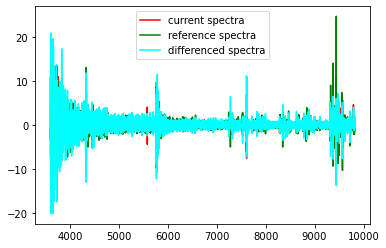

INFO:spectra.py:253:read_spectra: iotime 0.923 sec to read spectra-0-1395-thru20210606.fits at 2021-08-05T17:35:52.391960
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.971 sec to read spectra-7-1407-thru20210606.fits at 2021-08-05T17:35:53.805712
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.178 sec to read spectra-1-1394-thru20210606.fits at 2021-08-05T17:35:55.419343
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.988 sec to read spectra-7-20079-thru20210606.fits at 2021-08-05T17:35:56.849190
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.990 sec to read spectra-9-2197-thru20210606.fits at 2021-08-05T17:35:58.366318
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.925 sec to read spectra-6-1200-thru20210606.fits at 2021-08-05T17:35:59.751358
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.133 sec to read spectra-5-1239-thru20210606.fits at 2021-08-05T17:36:01.299275
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.921 sec to read spectra-4

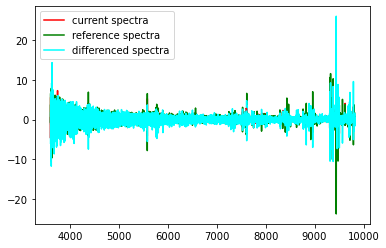

INFO:spectra.py:253:read_spectra: iotime 1.116 sec to read spectra-2-20112-thru20210606.fits at 2021-08-05T17:36:19.198378
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.936 sec to read spectra-7-20112-thru20210606.fits at 2021-08-05T17:36:20.568512
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.012 sec to read spectra-9-1239-thru20210606.fits at 2021-08-05T17:36:22.029142
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.072 sec to read spectra-4-1242-thru20210606.fits at 2021-08-05T17:36:23.538245
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.942 sec to read spectra-9-20079-thru20210606.fits at 2021-08-05T17:36:25.007755
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.578 sec to read spectra-0-21195-thru20210606.fits at 2021-08-05T17:36:27.015482
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.136 sec to read spectra-9-1200-thru20210606.fits at 2021-08-05T17:36:28.599128
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.081 sec to read spectr

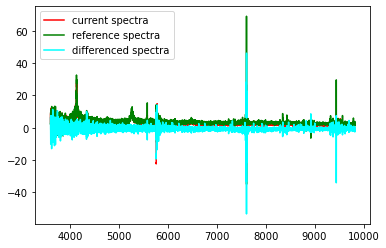

INFO:spectra.py:253:read_spectra: iotime 0.934 sec to read spectra-9-1219-thru20210606.fits at 2021-08-05T17:36:46.640832
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.942 sec to read spectra-2-1407-thru20210606.fits at 2021-08-05T17:36:48.007670
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.992 sec to read spectra-6-1910-thru20210606.fits at 2021-08-05T17:36:49.497560
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.995 sec to read spectra-1-2163-thru20210606.fits at 2021-08-05T17:36:50.953573
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.002 sec to read spectra-2-1910-thru20210606.fits at 2021-08-05T17:36:52.391374
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.390 sec to read spectra-3-1882-thru20210606.fits at 2021-08-05T17:36:54.218886
[20210602]


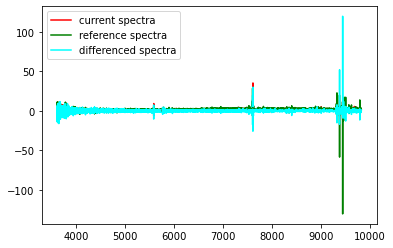

INFO:spectra.py:253:read_spectra: iotime 1.130 sec to read spectra-6-1387-thru20210606.fits at 2021-08-05T17:36:56.488742
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.119 sec to read spectra-4-2203-thru20210606.fits at 2021-08-05T17:36:58.040483
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.030 sec to read spectra-0-1219-thru20210606.fits at 2021-08-05T17:36:59.512458
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.971 sec to read spectra-5-1418-thru20210606.fits at 2021-08-05T17:37:00.920008
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.128 sec to read spectra-3-1387-thru20210606.fits at 2021-08-05T17:37:02.482852
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.105 sec to read spectra-6-1246-thru20210606.fits at 2021-08-05T17:37:04.019085
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.966 sec to read spectra-8-1407-thru20210606.fits at 2021-08-05T17:37:05.431762
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.971 sec to read spectra-1-

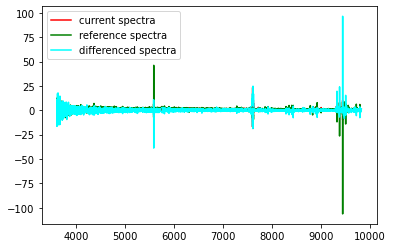

INFO:spectra.py:253:read_spectra: iotime 0.938 sec to read spectra-9-2163-thru20210606.fits at 2021-08-05T17:38:24.248795
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.950 sec to read spectra-5-1230-thru20210606.fits at 2021-08-05T17:38:25.630421
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.007 sec to read spectra-2-2163-thru20210606.fits at 2021-08-05T17:38:27.070312
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.947 sec to read spectra-8-1200-thru20210606.fits at 2021-08-05T17:38:28.497916
[20210602]
INFO:spectra.py:253:read_spectra: iotime 1.073 sec to read spectra-1-1418-thru20210606.fits at 2021-08-05T17:38:30.050640
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.934 sec to read spectra-9-20079-thru20210606.fits at 2021-08-05T17:38:31.475022
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.949 sec to read spectra-7-1246-thru20210606.fits at 2021-08-05T17:38:32.857102
[20210602]
INFO:spectra.py:253:read_spectra: iotime 0.944 sec to read spectra-6

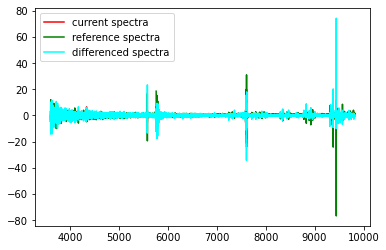

INFO:spectra.py:253:read_spectra: iotime 1.778 sec to read spectra-7-1117-thru20210606.fits at 2021-08-05T17:38:40.340455
[20210602]


KeyboardInterrupt: 

In [20]:
### pre-select yyyymmdd for debugging purposes

#for a in night_arr:   
    # read in and store in one place all the fibermap information in the spectra files
start_time = time.time()
yyyymmdd = 20210606 ### sample night used; also 20210406 is a good one for debugging
dats=[]
for filename in glob.glob(f"/global/project/projectdirs/desi/spectro/redux/daily/tiles/cumulative/*/{yyyymmdd}/spectra-*.fits"):
    t = Table.read(filename, format='fits',hdu=1, memmap=True)[['TARGETID','TARGET_RA','TARGET_DEC','TILEID','OBJTYPE','PETAL_LOC', 'NIGHT']]
    t=t[t['OBJTYPE']=='TGT']
    dats.append(t)
dats=vstack(dats, join_type='inner',metadata_conflicts='silent')
# group all the observations by TARGET_RA and TARGET_DEC
# note that this is more reliable than grouping by TARGETID as TARGETID is NOT a unique identifier of RA and DEC
dats_group = dats.group_by(['TARGET_RA','TARGET_DEC'])

# for each group make a tuple containing all tileid/petal combinations that have that ra/dec
tile_petal=[]
night=[]
print("# for each group make a tuple containing all tileid/petal combinations that have that ra/dec")
for g in dats_group.groups:
    
    gu = unique(g, keys=['TILEID'])
    dum=[]
    for a,b,c in zip(gu['TILEID'],gu['PETAL_LOC'],gu['TARGETID']):
        dum.append((a,b,c))
    tile_petal.append(tuple(dum))


    du = unique(g, keys=['NIGHT'])
    for d in zip(du['NIGHT']):
        night.append((d))
    
# compress things down to the unique tile/petal combinations
print("# compress things down to the unique tile/petal combinations")
tile_petal = list(set(tile_petal))
# union sets that have intersecting tile/petal combinations
print("# union sets that have intersecting tile/petal combinations")
for i in range(len(tile_petal)-1,0,-1):
    for j in range(i-1,-1,-1):
        if len(set(tile_petal[i]) & set(tile_petal[j])) !=0:
            tile_petal[j]=tile_petal[i]+tile_petal[j]
            del tile_petal[i]
            break
# unique of each set
for i in range(len(tile_petal)):
    tile_petal[i]=list(set(tile_petal[i]))

#  compress night into only one instance of each
print("#  compress night into only one instance of each")

unique_night = numpy.unique(night)
print(unique_night)
print("--- %s seconds ---" % (time.time() - start_time)) # at first running with yyyymmdd = 20210606, --- 7328.956216812134 seconds ---

# pull out one tileid/petal combination to build current and reference spectra with
for i in tile_petal:
    spectra = Spectra()
    dif_spectra = Spectra()
    ref_spectra = Spectra() ###or else NameError at 'if ref_spectra.num_spectra'... in the case of no reference nights
    for j in i:
        filename =  f"/global/project/projectdirs/desi/spectro/redux/daily/tiles/cumulative/{j[0]}/{yyyymmdd}/spectra-{j[1]}-{j[0]}-thru{yyyymmdd}.fits"
        spectra = read_spectra(filename)
        date = numpy.array(yyyymmdd)
        idx = numpy.in1d(unique_night, date)
        ref_night = unique_night[~idx]
        try:
            cur_spectra = (spectra.select(nights=date, targets = [j[2]]))
            ref_spectra = (spectra.select(nights=ref_night, targets = [j[2]]))
        except:
            pass ###this is the mechanism for eliminating targets that have no reference nights. 
        #print(ref_spectra.num_spectra())

        if ref_spectra.num_spectra() != 0:
        ###in the case of no ref nights, as 'pass' has allowed a reference spectra to be created despite a RuntimeError, this is the check that there is something to difference
            coadd(ref_spectra)
            dif_spectra.update(cur_spectra)
            coadd(dif_spectra)
            for b in dif_spectra.bands:
                dif_spectra.flux[b][0] = cur_spectra.flux[b][0]-ref_spectra.flux[b][0]
                ok = numpy.logical_and(dif_spectra.mask[b][0,:] == 0, dif_spectra.ivar[b][0] != 0)
                plt.plot(cur_spectra.wave[b][ok], cur_spectra.flux[b][0,ok], color = 'red', label = "current spectra")
                plt.plot(ref_spectra.wave[b][ok],ref_spectra.flux[b][0,ok], color = 'green', label = 'reference spectra')
                plt.plot(dif_spectra.wave[b][ok],dif_spectra.flux[b][0,ok], color = 'cyan', label = 'differenced spectra')
                if b == 'b':
                    plt.legend()
            #plt.xlim(3600, 3650)
            plt.show()
            """ 
            # save each days candidate plots into one pdf
            with PdfPages('diff_candidates(%d).pdf' % yyyymmdd) as pdf:
                fig = plt.figure()
                pdf.savefig(fig)
            """



In [11]:
import time
from datetime import date, timedelta, datetime
import psycopg2
import sqlite3
import os
import numpy

#get array of yyyymmdds to loop through
#getUnprocessedDates.py
def getUnprocessedDates():
    start_time = time.time()
    # Connect to desi.db with POSTGRES to get latest observed and unprocessed yyyymmdd
    f = open('/global/cscratch1/sd/clepart/desi_pg.txt') #what is more valid?
    file = f.read()
    db_name, db_user, db_pwd, db_host = file.split()
    conn = psycopg2.connect(dbname=db_name, user=db_user, password=db_pwd, host=db_host)
    cur = conn.cursor()
    cur.execute("""SELECT DISTINCT yyyymmdd from fibermap_daily WHERE yyyymmdd > 20210604""") #most recent, remove in future
    desi_arr = cur.fetchall()
    cur.close()
    conn.close()
    
    # Open to transients_search.db for latest processed yyyymmdd to do comparison with unprocessed
    filename_conn = "/global/cfs/cdirs/desi/science/td/daily-search/transients_search.db"
    conn = sqlite3.connect(filename_conn)
    trans_arr = conn.execute("""SELECT DISTINCT yyyymmdd from unprocessed_exposures""").fetchall()
    conn.close()

    # Compare yyyymmdd from fibermap_daily with unprocessed_exposures, retaining those in fibermap_daily and not in unprocessed_daily
    night_arr = numpy.setdiff1d(desi_arr, trans_arr)

    print('len(night_arr): ' + str(len(night_arr)))
    print("--- get unprocessed dates took:  %s seconds ---" % (time.time() - start_time))
    
    return(night_arr) 

In [22]:
for g in dats_group:
    if g['NIGHT']==20210605:
        print(g)